In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
# Import base dataset
base = pd.read_csv("FinanceData/Base.csv")
# base.head()

In [6]:
# Convert Numerical predictors to categorical ones based on feature's quartiles
# NOTE: Future data will require this to be recalculated, and probs isn't best for prod-model
def convert_to_quartiles(df, feature):
    # Calculate quartiles
    q1 = df[feature].quantile(0.25)
    q2 = df[feature].quantile(0.50)
    q3 = df[feature].quantile(0.75)
    
    # Bin the data based on quartile ranges
    bins = [-float('inf'), q1, q2, q3, float('inf')]
    # these labels will more than likely need updated 
    labels = ["low", "med-low", "med-high", "high"]
    
    # Remove duplicate bins and adjust labels
    unique_bins = list(sorted(set(bins)))  # Ensure bins are unique and sorted
    
    # Assign integer labels to each bin
    # Labels will always be [0, 1, 2, ..., n_bins - 2]
    quartile_series = pd.cut(df[feature], bins=unique_bins, labels=False, include_lowest=True)
    
    # Ensure integer type for compatibility with CategoricalNB
    return quartile_series.astype(int)

In [7]:
# Here, we are going to drop month, as I believe it shows data captured within an 8 month span, so its not helpful here
base.drop(columns=["month"], inplace=True)

In [8]:
# First, create list of all binary variables to use to exclude from numeric list
binary_classifiers = ["Fraud_bool", "email_is_free", "phone_home_valid", "phone_mobile_valid",
                      "has_other_cards", "foreign_request", "keep_alive_session"]

# Create list of numerical features all in binary_classifier list
numerical_cols = [col for col in base.select_dtypes(include='number').columns if col not in binary_classifiers]
numerical_cols = [col for col in base.select_dtypes(include='number').columns if col not in binary_classifiers]
# Create new binned df containing only the columns NOT in the numerical_cols list
binned_df = base.drop(columns=numerical_cols)

# Convert remaining numerical columns to be categorical features based on quantiles
for col in numerical_cols:
    binned_df[col] = convert_to_quartiles(base, col)

# Final dataframe should have same dim as base (remembering of course we excluded month)
print("Shape of base df: " + str(base.shape))
print("Shape of binned df: " + str(binned_df.shape))

Shape of base df: (1000000, 31)
Shape of binned df: (1000000, 31)


In [9]:
# Collect all normal categorical variables (non-binary/boolean)
categorical_vars = ["payment_type", "employment_status", "housing_status", "source", "device_os"]

# Initialize Label Encoder object
le = LabelEncoder()

# Use Integer Encoding to convert the other categorical variables to be integer-based too 
for col in categorical_vars:
    binned_df[col] = le.fit_transform(binned_df[col])

In [12]:
# Create Train and Test data
# Implement K-fold Cross-Validation and SMOTE oversampling to create train set with a lot of fraud cases

# First, split features from predicitor series
# Make sure to drop the target value from X!!!
X = binned_df.drop("fraud_bool",axis=1)
y = base["fraud_bool"]

# Initialize the Naive Bayes classifier
nb = CategoricalNB()

# Create a pipeline with SMOTE and Naive Bayes
# pipeline = Pipeline([('smote', smote), ('naive_bayes', nb)])

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5525)

# Initialize performance metrics storage bins
accuracy_list = []
precision_list = []
f1_score_list = []
all_y_true = []
all_y_pred_proba = []
fold_auc_scores = []
agg_conf_matrix = np.zeros((2, 2), dtype=int) #for confusion matrix

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model using the NB Classifier
    nb.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = nb.predict(X_test)

    # Calculate and store key performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    y_pred_proba = nb.predict_proba(X_test)[:, 1]
    fold_auc = roc_auc_score(y_test, y_pred_proba)
    fold_conf_matrix = confusion_matrix(y_test, y_pred)

    # Store and Update current fold's performance metrics
    accuracy_list.append(accuracy)
    f1_score_list.append(f1_metric)
    precision_list.append(precision)
    fold_auc_scores.append(fold_auc)
    agg_conf_matrix += fold_conf_matrix
    all_y_true.extend(y_test)
    all_y_pred_proba.extend(y_pred_proba)

In [13]:
# Results
print("Average Prediction Accuracy: " + str(np.mean(accuracy_list)))
print("Average F1 Score: " + str(np.mean(f1_score_list)))
print("Average Precision: " + str(np.mean(precision_list)))

Average Prediction Accuracy: 0.9735520000000001
Average F1 Score: 0.19139282834921006
Average Precision: 0.14446336265779083


In [14]:
# Calculate ROC, AUC, and Confusion Matrix Results
mean_auc = np.mean(fold_auc_scores)
fpr, tpr, _ = roc_curve(all_y_true, all_y_pred_proba)

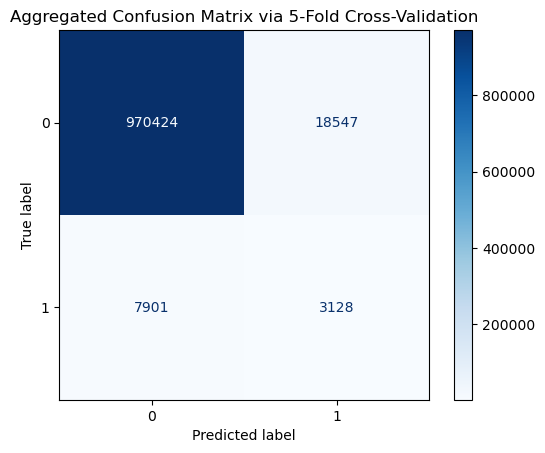

In [55]:
# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=agg_conf_matrix,
                              display_labels=nb.classes_)
disp.plot(cmap="Blues")
plt.title("Aggregated Confusion Matrix via 5-Fold Cross-Validation")
plt.show()

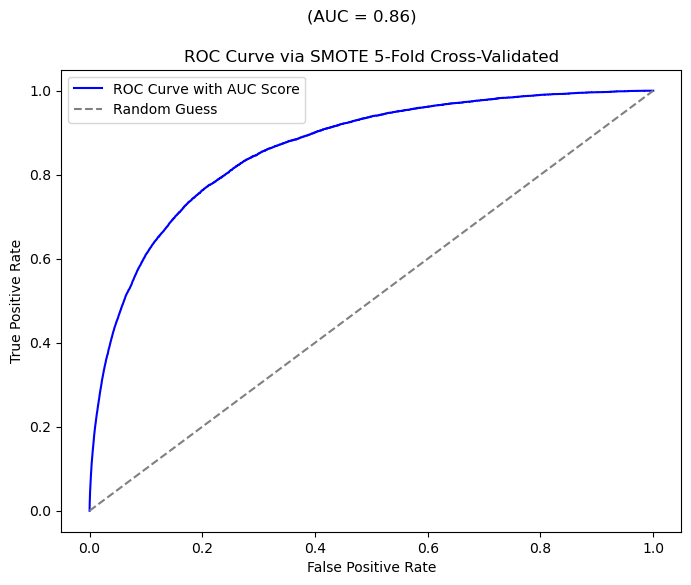

In [19]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve with AUC Score", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("ROC Curve 5-Fold Cross-Validated")
plt.suptitle(f"(AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Removing SMOTE vastly improved our False-Positive rate, Precision, and Accuracy values. we also have a decent AUC curve, but need to improve upon the model.

# Re-train the model now over 15-20 times with different splits on train and test, and plot the % of data in the train set on X with Accuracy, Precision % on the Y

In [29]:
train_split = list(np.arange(0.05, 1.0, 0.05))
train_accuracies = []
train_precisions = []
test_accuracies = []
test_precisions = []

for split_val in train_split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - split_val))
    
    # Train new model
    nb.fit(X_train, y_train)
    
    # Predict on Train and Test sets using model
    y_test_pred = nb.predict(X_test)
    y_train_pred = nb.predict(X_train)
    
    # Collect Metrics
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    train_precisions.append(precision_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))
    test_precisions.append(precision_score(y_test, y_test_pred))

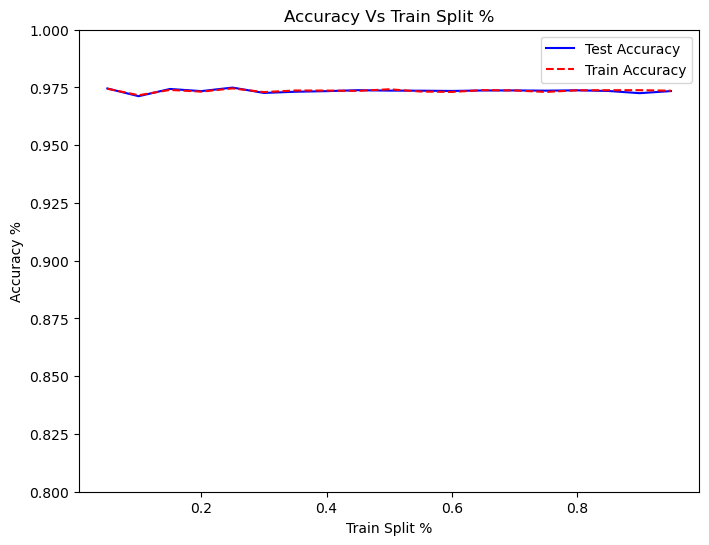

In [36]:
# PLot relationship between train split and accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_split, test_accuracies, label="Test Accuracy", color='blue')
plt.plot(train_split, train_accuracies, linestyle="--", color="red", label="Train Accuracy")
plt.title("Accuracy Vs Train Split %")
plt.xlabel('Train Split %')
plt.ylabel("Accuracy %")
plt.ylim(0.8, 1)
plt.legend()
plt.show()

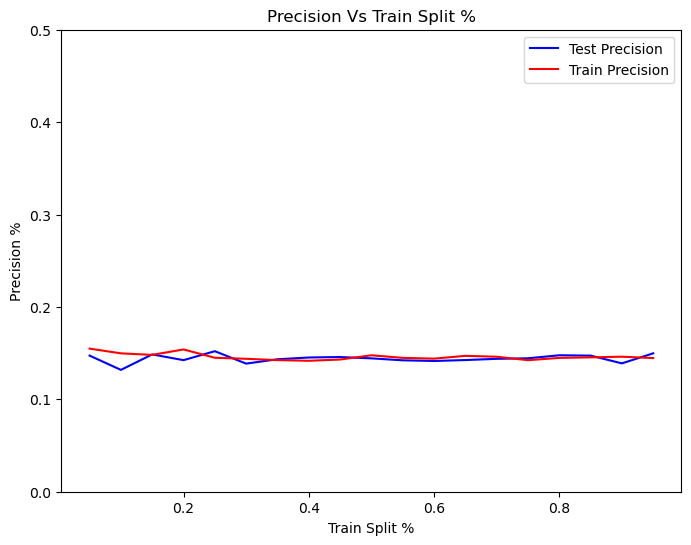

In [38]:
# PLot relationship between train split and accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_split, test_precisions, label="Test Precision", color='blue')
plt.plot(train_split, train_precisions, color="red", label="Train Precision")
plt.title("Precision Vs Train Split %")
plt.xlabel('Train Split %')
plt.ylabel("Precision %")
plt.ylim(0.0, 0.5)
plt.legend()
plt.show()

# Precision and Accuracy plots show that regardless of the size of train set, our prediction of true positives remains pretty constant

# Why is that? Could increasing the smoothing term help? Let's test that efffect

In [56]:
# Test effect of alpha on data to see if increase helps 
# Base alpha smoothing parameter by percentage of fraud cases in train set
# use same train_split list from before
alpha_pcts = list(np.arange(0.01, 0.21, 0.01))
alpha_values = []

train_accuracies = []
train_precisions = []
test_accuracies = []
test_precisions = []

# Use same train, test split for every example
# Base alpha off of sizes of train set
# alpha = alpha_pct * train_set_size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

for pct in alpha_pcts:
    # Determine alpha value
    alpha_val = pct * np.sum(y_train)
    alpha_values.append(alpha_val)
    
    # Create new NB Classifier for given alpha value
    nb = CategoricalNB(alpha=alpha_val)
    
    # Train new model
    nb.fit(X_train, y_train)
    
    # Predict on Train and Test sets using model
    y_test_pred = nb.predict(X_test)
    y_train_pred = nb.predict(X_train)
    
    # Count instances of 1 (fraud) predicted
    # Check to see if fraud cases are appearing correctly in data
#     print(np.sum(y_test_pred))
#     print(np.sum(y_train_pred))
    
    # Collect Metrics
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    train_precisions.append(precision_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))
    test_precisions.append(precision_score(y_test, y_test_pred))

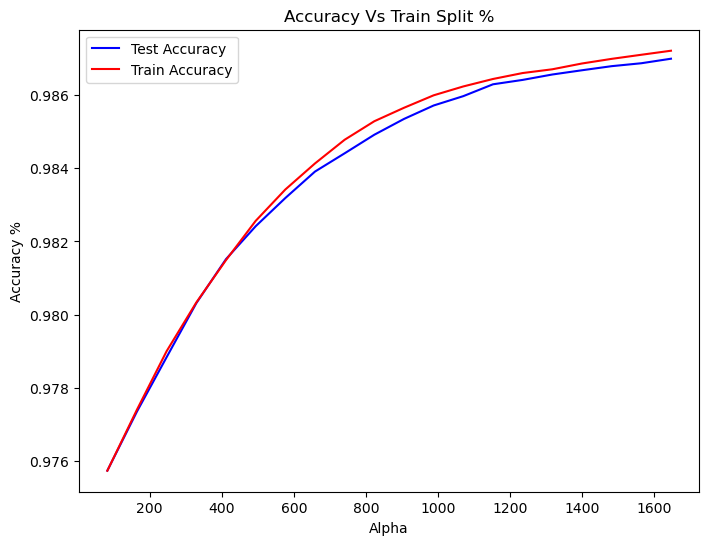

In [52]:
# Make same plots from before, but wiht alpha values on the X
# Accuracy
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, test_accuracies, label="Test Accuracy", color='blue')
plt.plot(alpha_values, train_accuracies, color="red", label="Train Accuracy")
plt.title("Accuracy Vs Train Split %")
plt.xlabel('Alpha')
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

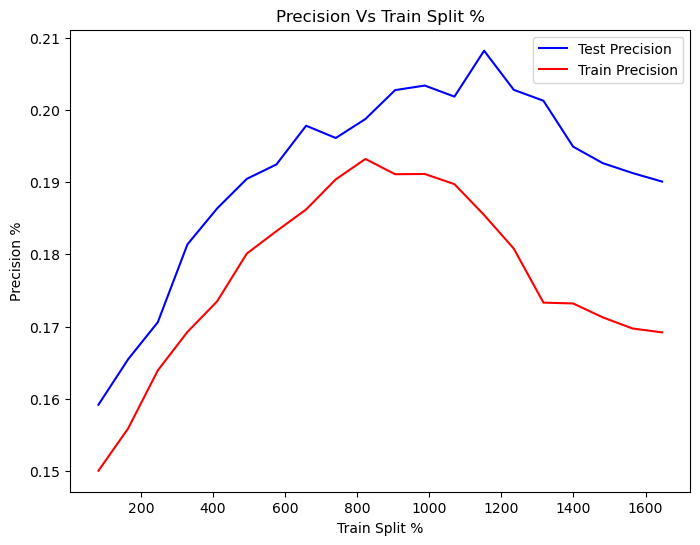

In [53]:
# Precision
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, test_precisions, label="Test Precision", color='blue')
plt.plot(alpha_values, train_precisions, color="red", label="Train Precision")
plt.title("Precision Vs Train Split %")
plt.xlabel('Train Set Size')
plt.ylabel("Precision %")
plt.legend()
plt.show()

# We cna see the optimal value of alpha here! But, notice how we are nowhere near 1, but did view an improvement in precision. 
# I think this really highlights this algorithms performance in a general situation. Running these same steps on the other skewed data sets could prove beneficial for seeing if only the general case struggles, or if there are certain situations there is a significant improvement in